## Set up environment

In [2]:
import os
from dotenv import load_dotenv

load_dotenv()

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
LANGCHAIN_API_KEY = os.getenv('LANGCHAIN_API_KEY')
LANGCHAIN_ENDPOINT = os.getenv('LANGCHAIN_ENDPOINT')
LANGCHAIN_TRACING_V2 = os.getenv('LANGCHAIN_TRACING_V2')
GPT_3 = os.getenv('GPT_3')
GPT_4 = os.getenv('GPT_4')

## Configure the database

In [3]:
import requests
url = "https://storage.googleapis.com/benchmarks-artifacts/chinook/Chinook.db"

response = requests.get(url)

if response.status_code == 200:
    # Open a local file in binary write mode
    with open("Chinook.db", "wb") as file:
        # Write the content of the response (the file) to the local file
        file.write(response.content)
    print("File downloaded and saved as Chinook.db")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

File downloaded and saved as Chinook.db


## SQL Agent

In [4]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM Artist LIMIT 10;")

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

## LLM

In [5]:
from langchain_openai import ChatOpenAI

llm=ChatOpenAI(model="gpt-4o",temperature=0)
experiment_prefix="sql-agent-gpt4o"
metadata = "Chinook, gpt-4o base-case-agent"

## Tools

In [6]:
import json
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, MessageGraph
from langgraph.prebuilt.tool_node import ToolNode
from langchain_core.messages import AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain.agents import tool

# SQL toolkit
toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()

# Query checking
query_check_system = """You are a SQL expert with a strong attention to detail.
Double check the SQLite query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

Execute the correct query with the appropriate tool."""
query_check_prompt = ChatPromptTemplate.from_messages([("system", query_check_system),("user", "{query}")])
query_check = query_check_prompt | llm

@tool
def check_query_tool(query: str) -> str:
    """
    Use this tool to double check if your query is correct before executing it.
    """
    return query_check.invoke({"query": query}).content

# Query result checking
query_result_check_system = """You are grading the result of a SQL query from a DB.
- Check that the result is not empty.
- If it is empty, instruct the system to re-try!"""
query_result_check_prompt = ChatPromptTemplate.from_messages([("system", query_result_check_system),("user", "{query_result}")])
query_result_check = query_result_check_prompt | llm

@tool
def check_result(query_result: str) -> str:
    """
    Use this tool to check the query result from the database to confirm it is not empty and is relevant.
    """
    return query_result_check.invoke({"query_result": query_result}).content

tools.append(check_query_tool)
tools.append(check_result)

## State

In [7]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

## SQL assistant

In [16]:
# Assistant
class Assistant:

    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            # Append to state
            state = {**state}
            # Invoke the tool-calling LLM
            result = self.runnable.invoke(state)
            # If it is a tool call -> response is valid
            # If it has meaninful text -> response is valid
            # Otherwise, we re-prompt it b/c response is not meaninful
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}

# Assistant runnable
query_gen_system = """
ROLE:
You are an agent designed to interact with a SQL database. You have access to tools for interacting with the database.
GOAL:
Given an input question, create a syntactically correct SQLite query to run, then look at the results of the query and return the answer.
INSTRUCTIONS:
- Only use the below tools for the following operations.
- Only use the information returned by the below tools to construct your final answer.
- To start you should ALWAYS look at the tables in the database to see what you can query. Do NOT skip this step.
- Then you should query the schema of the most relevant tables.
- Write your query based upon the schema of the tables. You MUST double check your query before executing it.
- Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
- You can order the results by a relevant column to return the most interesting examples in the database.
- Never query for all the columns from a specific table, only ask for the relevant columns given the question.
- If you get an error while executing a query, rewrite the query and try again.
- If the query returns a result, use check_result tool to check the query result.
- If the query result result is empty, think about the table schema, rewrite the query, and try again.
- DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database."""

query_gen_prompt = ChatPromptTemplate.from_messages([("system", query_gen_system),("placeholder", "{messages}")])
assistant_runnable = query_gen_prompt | llm.bind_tools(tools)

## Graph utilities

In [9]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda

def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )

def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print(f"Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

## Graph

In [10]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

# Graph
builder = StateGraph(State)

# Define nodes: these do the work
builder.add_node("assistant", Assistant(assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(tools))

# Define edges: these determine how the control flow moves
builder.set_entry_point("assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
    # "tools" calls one of our tools. END causes the graph to terminate (and respond to the user)
    {"tools": "tools", END: END},
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
memory = SqliteSaver.from_conn_string(":memory:")
my_graph = builder.compile(checkpointer=memory)

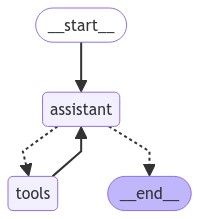

In [11]:
from IPython.display import Image, display

display(Image(my_graph.get_graph(xray=True).draw_mermaid_png()))

## Test

In [14]:
questions = ["Which country's customers spent the most? And how much did they spend?",
             "How many albums does the artist Led Zeppelin have?",
             "What was the most purchased track of 2017?",
             "Which sales agent made the most in sales in 2009?"]

In [15]:
## Invoke
import uuid
_printed = set()
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

msg = {"messages": ("user", questions[0])}
messages = my_graph.invoke(msg,config)
messages['messages'][-1].content

## Stream
import uuid
_printed = set()
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

events = my_graph.stream(
    {"messages": ("user", questions[0])}, config, stream_mode="values"
)
for event in events:
    _print_event(event, _printed)

================================ Human Message =================================

Which country's customers spent the most? And how much did they spend?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_eS1fBxhBCqX625LNWAPMjint)
 Call ID: call_eS1fBxhBCqX625LNWAPMjint
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_z1jPzqrL9B69oK5BscS6juL4)
 Call ID: call_z1jPzqrL9B69oK5BscS6juL4
  Args:
    table_names: Customer, Invoice
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "Customer" (
	"CustomerId" INTEGER NOT NULL, 
	"FirstName" NVARCHAR(40) NOT NULL, 
	"LastName" NVARC